In [1]:
import numpy as np 
import pandas as pd
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA # To reduce dimensions for visualization
import seaborn as sns # For making plots

import matplotlib.pyplot as plt

# Loading Data

In [2]:
#This is a classification task: to predict which industry (category) a company belongs to, based on its embedding.

df = pd.read_pickle("data/df_train.pkl")
# Splitting the data into 90% train and 10% validation sets
df_train, df_val = train_test_split(df, test_size= 0.1, random_state=42)

In [3]:
#Text embeddings -> way to turn text into numeric vectors that capture the semantic meaning of the text
#Here, we convert the string representation of the list back to an actual list using ast.literal_eval
#Pre-computed to save time
# X_train -> business description embeddings for training set
X_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_train = np.array(X_train)

X_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_val = np.array(X_val)

In [4]:
df_train.head(3)

,id,industry,business_description_embedding
31138,34170,Financial Services,"[0.019633012,0.009427597,0.006240986,0.0177257..."
15120,16504,Technology Hardware & Equipment,"[0.026561439,-0.049749356,-0.006847293,-0.0088..."
23693,25893,Consumer Durables & Apparel,"[0.0115894,-0.035240766,-0.029952582,0.0226988..."


# Transforming Data (Label Encoding)

### Tasks:
- Use the scikit-learn label encoder to encode the industry names
- Check if all classes contained in the validation set are also in the training set

In [5]:
# Fit the label encoder to the classes (industry names)
# "industry" is your target label (the “y” or what you want to predict).
le = LabelEncoder()
le.fit(df_train['industry'])

# y-train -> Transform the industry names to numerical labels
y_train = le.transform(df_train['industry'])
y_val =  le.transform(df_val['industry'])

In [6]:
# Checking if classes contained in the validation set are also present in the training set
train_classes = set(df_train['industry'].unique())
val_classes = set(df_val['industry'].unique())
if val_classes.issubset(train_classes):
    print("All classes in validation set are present in training set.")
else:
    missing_classes = val_classes - train_classes
    print(f"The following classes are missing in the training set: {missing_classes}")

All classes in validation set are present in training set.


# Visualize the data

### Tasks:
- Are certain classes over- or under represented? Either produce a table or a plot to show this.
- Inspect whether there is signal in the business description embeddings:
    - Perform a PCA to project data into 2 dimensions
    - Plot projected data in Scatterplot and color based on classes
    - Provide a description of what you see and judge whether there is signal in the data that allows industry classification

Important: Ensure that your plots have proper axis descriptions and titles. Style the plots so that differences in class distributions are visible (e.g. scatter size, transparency, color, etc.)

### Class distribution

In [7]:
# Plot the class distribution or provide a table that shows how many times each class (industry) appears
# Describe your findings
class_counts = df_train['industry'].value_counts()

#Table showing counts of each industry class
count_df = pd.DataFrame({'Industry': class_counts.index, 'Number of Companies': class_counts.values})
count_df

,Industry,Number of Companies
0,Materials,7604
1,Capital Goods,2805
2,"Pharmaceuticals, Biotechnology & Life Sciences",1742
3,Financial Services,1740
4,Technology Hardware & Equipment,1390
5,Software & Services,1384
6,Energy,1174
7,Consumer Durables & Apparel,1037
8,"Food, Beverage & Tobacco",956
9,Health Care Equipment & Services,911


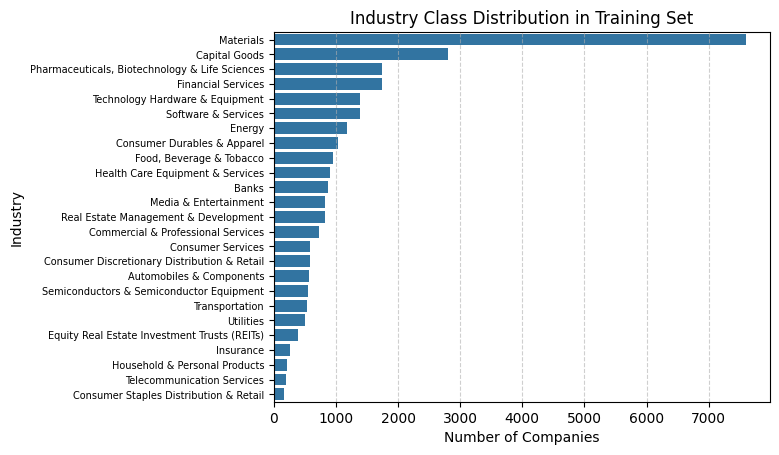

In [8]:
#Visualizing the class distribution
class_distribution = sns.barplot(x=class_counts.values, y=class_counts.index, orient = 'h')
class_distribution.set_xlabel("Number of Companies")
class_distribution.set_ylabel("Industry")
class_distribution.set_title("Industry Class Distribution in Training Set")
class_distribution.grid(axis='x', linestyle='--', alpha=0.6)
class_distribution.tick_params(axis='y', labelsize=7)

### Findings
Materials industry is over-represented as it heavly dominates the data with over > 7000 companies. Certain industries like Insurance, Household & Personal Products, Telecom. Services and Consumer Staples Distribution & Retail are extremely under-represented with < 300 companies

### PCA - Dimensionality reduction and visualization

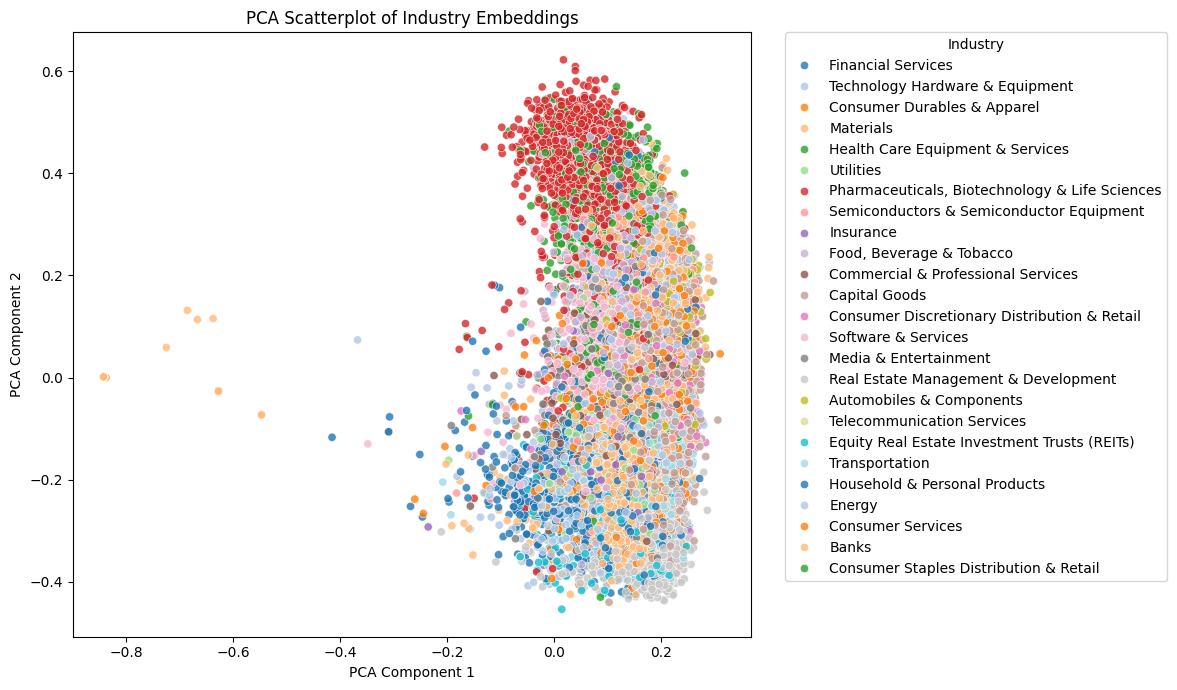

In [9]:
# Performa a PCA and plot the projected data. Color the scatter plot based on the classes
# Analyse what you see

# Performing PCA to reduce dimensions to 2D for visualization i.e industry descriptions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Creating a DataFrame for visualization
pca_df = pd.DataFrame(data=X_train_pca, columns=['PCA1', 'PCA2'])
# Adding the industry labels for coloring the scatter plot
pca_df['Industry'] = df_train['industry'].values

plt.figure(figsize=(12,7))
# Plotting the PCA results
ax = sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Industry', palette='tab20', alpha=0.8)

# Add a legend outside the plot
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Scatterplot of Industry Embeddings")
plt.tight_layout()
plt.show()


### Analysis
Although the plot shows quite significant overlap among industries, certain trends and partial separations can still be observed. For instance, the "Pharmaceuticals, Biotechnology & Life Sciences" industry, highlighted in red, appears relatively compact and well-clustered. This suggests that some underlying structure is indeed present in the data.

# Fitting and comparing Classifier Models

### Tasks:
- Split the data into train and validation data
- Encode the industry labels using LabelEncoder (scikit-learn)
- Fit a LogisticRegression and a kNN-classifier
- Compare the model performance of both models:
    - Compute Accuracy and F1 score
        - Interpret the scores: Explain how they are computed and judge if your model performs well
        - Analyze the classification errors: 
            - Do the errors correlate with how well classes are represented?
            - Which industries does the model identify well and which seem to be similar?
    - Plot a confusion matrix for both models (combine scikit-learn confusion matrix and seaborn heatmap plot)
    - Do both models misclassify the same examples?

Import: Use proper axis labels for the plots! 

In [10]:
# your code
df = pd.read_pickle("data/df_train.pkl")
# Splitting the data into 90% train and 10% validation sets
df_train, df_val = train_test_split(df, test_size= 0.1, random_state=42)

#Test Embeddings
X_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_train = np.array(X_train)

X_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_val = np.array(X_val)

#Lablel Encoding
le = LabelEncoder()
le.fit(df_train['industry'])
y_train = le.transform(df_train['industry'])
y_val =  le.transform(df_val['industry'])

#Create and fit Logistic Regression model
log_reg_model = LogisticRegression(max_iter=500)
log_reg_model.fit(X_train, y_train)

#Create and fit KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [11]:
# Predict on validation set
y_val_pred_log_reg = log_reg_model.predict(X_val)
y_val_pred_knn = knn_model.predict(X_val)

# Computing accuracy and F1-score for Logistic Regression
log_reg_accuracy = accuracy_score(y_val, y_val_pred_log_reg)
log_reg_f1 = f1_score(y_val, y_val_pred_log_reg, average='weighted')
print(f"Logistic Regression: \n Accuracy={log_reg_accuracy:.3f}, F1={log_reg_f1:.3f}")

# Computing accuracy and F1-score for KNN
knn_accuracy = accuracy_score(y_val, y_val_pred_knn)
knn_f1 = f1_score(y_val, y_val_pred_knn, average='weighted') 

print(f"KNN: \n Accuracy={knn_accuracy:.3f}, F1={knn_f1:.3f}")



Logistic Regression: 
 Accuracy=0.772, F1=0.766
KNN: 
 Accuracy=0.732, F1=0.730


### Interpreting scores
Accuracy is the percent of the number of correct predictions made to the total number of predicitons. While, F1 is the the balance between precision (how often the predicted industry is right) and recall (how many of the actual class members the model managed to find). This is especially important when we have some classes being over-represented. 

Logistic Regression model performed better in terms of both accuracy and F1 score. 

In [12]:
# Analysing the classification errors

report_dict = classification_report(y_val, y_val_pred_log_reg, target_names=le.classes_, output_dict=True)

# Storing the per-class support and F1 scores in a DataFrame for better visualization
class_names = le.classes_
supports = [report_dict[c]['support'] for c in class_names]
f1s = [report_dict[c]['f1-score'] for c in class_names]

summary_df = pd.DataFrame({
    'Class': class_names,
    'Support': supports,
    'F1': f1s
})

print("Industries with highest F1 scores:")
print(summary_df.sort_values('F1', ascending=False).head(3).to_string(index=False, float_format='{:0.3f}'.format))

print("\n\nIndustries with lowest F1 scores:")
print(summary_df.sort_values('F1', ascending=True).head(3).to_string(index=False, float_format='{:0.3f}'.format))

print("\n\nOverall Classification Report sorted by Support:")
summary_df.sort_values(by='Support', ascending=False)

Industries with highest F1 scores:
                   Class  Support    F1
                   Banks   74.000 0.951
               Materials  790.000 0.926
Food, Beverage & Tobacco  138.000 0.872


Industries with lowest F1 scores:
                                 Class  Support    F1
Consumer Staples Distribution & Retail   20.000 0.087
    Commercial & Professional Services   78.000 0.422
         Household & Personal Products   20.000 0.500


Overall Classification Report sorted by Support:


,Class,Support,F1
15,Materials,790.0,0.925903
2,Capital Goods,322.0,0.701449
10,Financial Services,196.0,0.774194
17,"Pharmaceuticals, Biotechnology & Life Sciences",183.0,0.838542
21,Technology Hardware & Equipment,157.0,0.615873
20,Software & Services,153.0,0.639752
8,Energy,152.0,0.666667
11,"Food, Beverage & Tobacco",138.0,0.872340
5,Consumer Durables & Apparel,127.0,0.632479
12,Health Care Equipment & Services,103.0,0.813725


### Analysing the classification errors
Support is the measure of the number of samples of a class. Industries with higher support like 'Materials' have a higher F1 score, meaning the model predicted them better. Industries with lower support like 'Consumer Staples Distribution & Retail' have an extremly low F1 score.Overall, industries that have smaller representation have performed poorer with expections like 'Banks', despite having a low support performed extremely well. 

Industries like ‘Materials’, ‘Banks’ and ‘Food, Beverage & Tobacco’ are identified well by the model. However, industries such as ‘Consumer Staples Distribution & Retail’, ‘Commercial & Professional Services’, and ‘Household & Personal Products’ are more misclassified which may be due to their lower representation or similarity in descriptions to other classes.

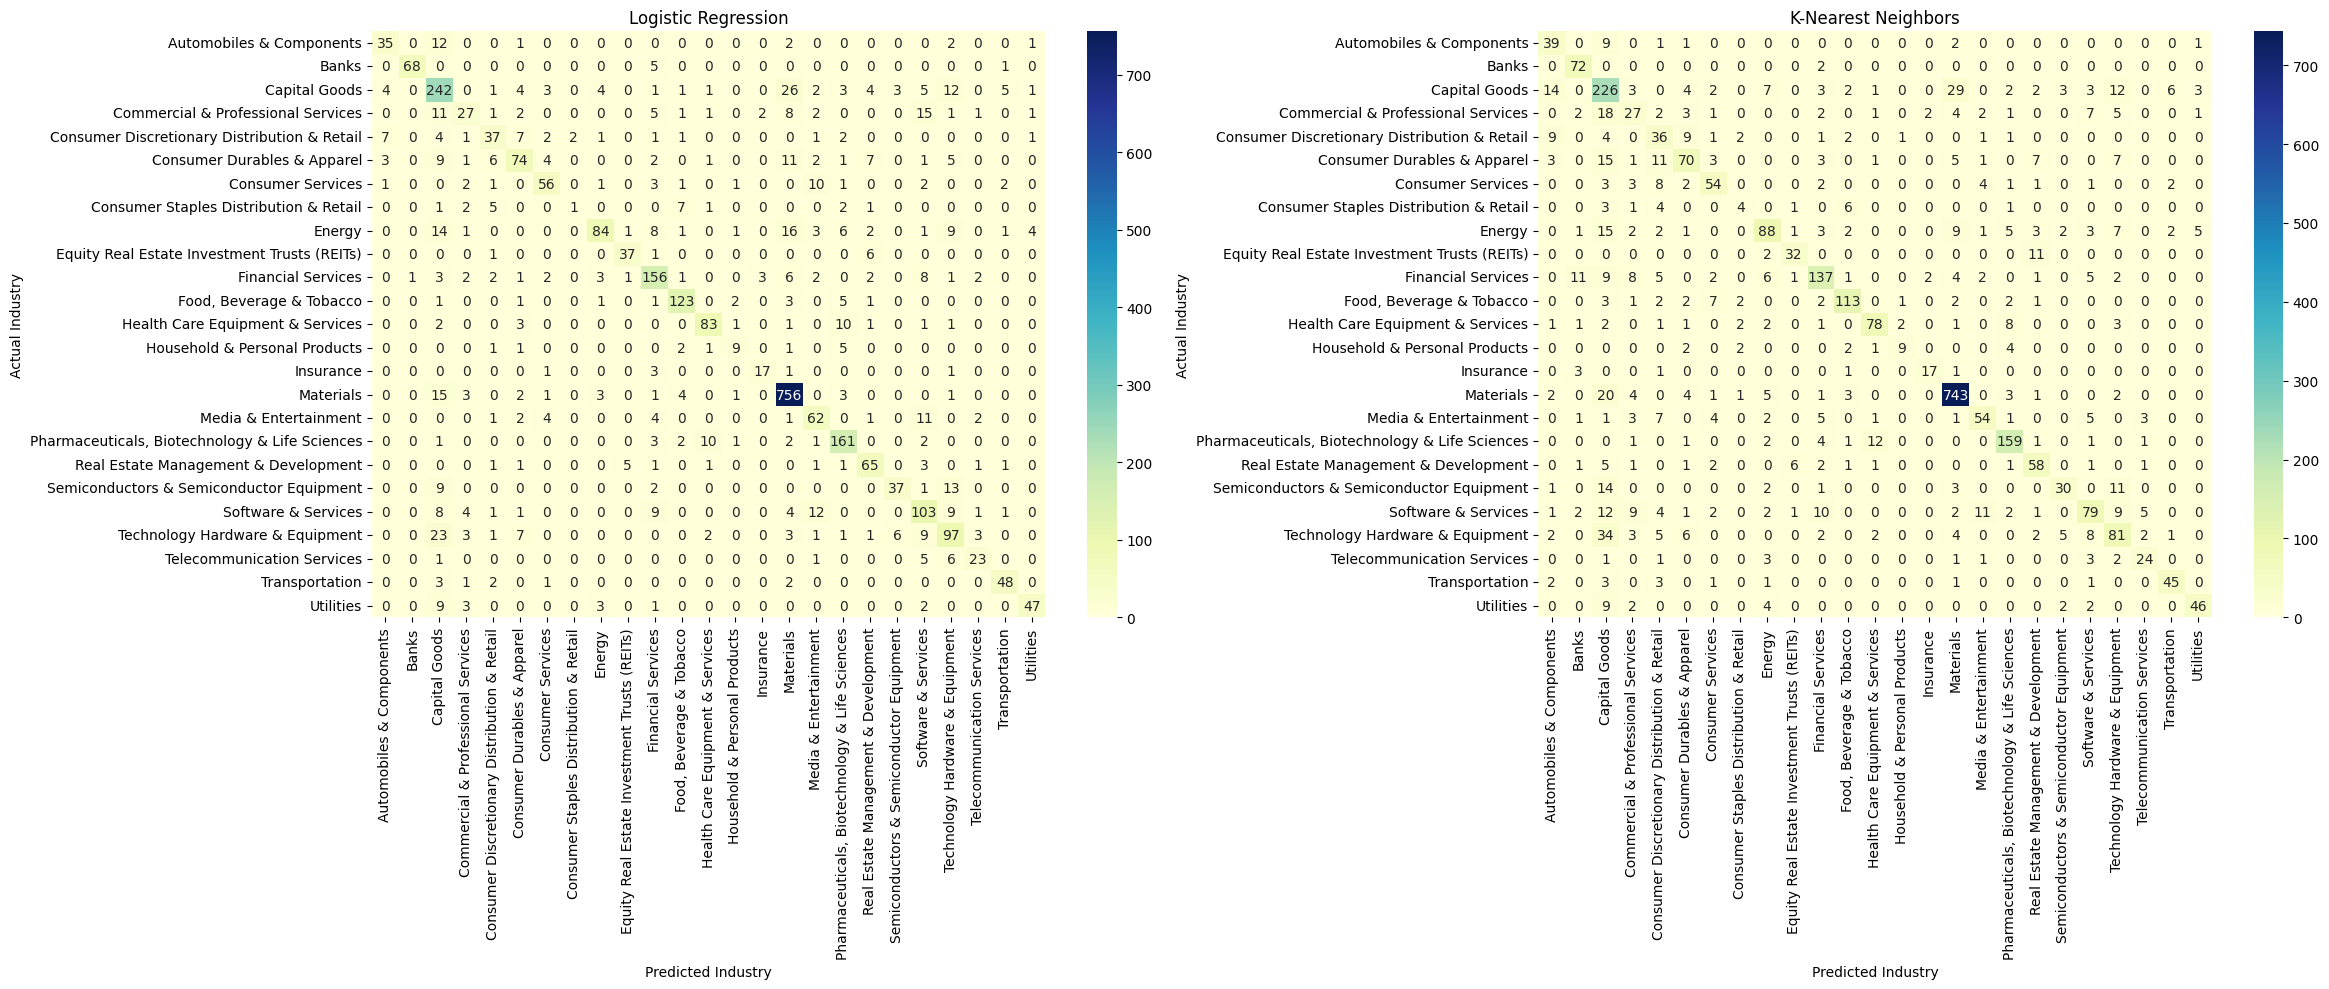

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_val, y_val_pred_log_reg)

plt_cm_log_reg = sns.heatmap(cm_log_reg, xticklabels=class_names, yticklabels=class_names, ax=axes[0], cmap="YlGnBu", annot=True, fmt="d")
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted Industry")
axes[0].set_ylabel("Actual Industry")

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_val, y_val_pred_knn)
plt_cm_knn = sns.heatmap(cm_knn, xticklabels=class_names, yticklabels=class_names, ax=axes[1], cmap="YlGnBu", annot=True, fmt="d")
axes[1].set_title("K-Nearest Neighbors")
axes[1].set_xlabel("Predicted Industry")
axes[1].set_ylabel("Actual Industry")

plt.tight_layout()
plt.show()


Both the logistic regression and k-nearest neighbors models show very similar confusion matrices. That means both the models are making mistakes on the same examples.

# Optional: Confidence Weighted Prediction

## Deliverables:

- Provide a notebook with the implementation and training of a industry classifier model
- The model shall output the industry classification and its confidence as a tuple of vectors $(\hat{y}_{pred}, \hat{y}_{confidence})$
- The confidence score must be between 0 and 1, $\hat{y}_{confidence} [i] \in [0,1]$
- Your model will be evaluated on a private test set
- The designing the confidence score is your task. You may use p-values, a voting mechanism of multiple models, or other techniques
- Another option is to add more features, e.g. financial data, to X

In [14]:
def confidence_weighted_f1(y_true, y_pred, confidence):
    # Weight all predictions, not just positives
    weighted_tp = np.sum(confidence * (y_pred == 1) * (y_true == 1))
    weighted_fp = np.sum(confidence * (y_pred == 1) * (y_true == 0))
    weighted_fn = np.sum(confidence * (y_pred == 0) * (y_true == 1))
    
    precision = weighted_tp / (weighted_tp + weighted_fp) if (weighted_tp + weighted_fp) > 0 else 0
    recall = weighted_tp / (weighted_tp + weighted_fn) if (weighted_tp + weighted_fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

In [15]:
df_financials = pd.read_pickle("data/df_financials_train.pkl")

#check the percentage of null values for each column against total number of rows
print((df_financials.isnull().sum() / len(df_financials)) * 100 )


id                    0.000000
country_code          0.000000
net_profit_margin     3.758330
ebitda_margin        65.217685
asset_turnover        4.610805
dtype: float64


In [16]:
#dropping ebita_margin as it has a lot of null values
df_financials = df_financials.drop(columns=['ebitda_margin'])

df_financials.columns

Index(['id', 'country_code', 'net_profit_margin', 'asset_turnover'], dtype='object')

In [17]:
#Replacing infinite values with NaN
df_financials['net_profit_margin'].replace([np.inf, -np.inf], np.nan, inplace=True)

#Setting unreasonable net profit margin values to NaN
df_financials.loc[(df_financials['net_profit_margin'] > 100) | (df_financials['net_profit_margin'] < -200), 'net_profit_margin'] = np.nan

df_financials['asset_turnover'].replace([np.inf, -np.inf], np.nan, inplace=True)

df_financials.describe()

# removing rows with both NaN values
df_financials = df_financials.dropna(subset=['net_profit_margin', 'asset_turnover'], how='all')

print(df_financials.head(3))

# combine df and df_financials on 'company_id'
df_combined = pd.merge(df, df_financials, on='id', how='inner')
df_combined

   id country_code  net_profit_margin  asset_turnover
0   0          CHN           0.303422        0.025426
1   1          CHN          -0.141921        0.266802
2   2          CHN          -1.333215        0.317023


C:\Users\basia\AppData\Local\Temp\ipykernel_4300\3089229143.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_financials['net_profit_margin'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\basia\AppData\Local\Temp\ipykernel_4300\3089229143.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

,id,industry,business_description_embedding,country_code,net_profit_margin,asset_turnover
0,42576,Banks,"[0.03411475,-0.03753958,0.023233214,-0.0017205...",USA,0.155503,0.033292
1,21752,Materials,"[-0.025557408,0.0636078,-0.01350581,-0.0180223...",DEU,0.023660,0.861915
2,804,Commercial & Professional Services,"[0.033574868,-0.020379327,-0.03221274,-0.01133...",CHN,0.001364,1.348739
3,31603,Insurance,"[0.020648101,0.017270269,-0.032921147,-0.01411...",IDN,0.022178,0.461366
4,11333,Capital Goods,"[-0.0006651232,0.011097765,-0.01976973,0.02299...",CHN,0.071349,0.555100
...,...,...,...,...,...,...
28379,6403,Capital Goods,"[0.022082254,-0.015513622,-0.029084805,0.02645...",CHN,0.032470,0.465017
28380,12224,Capital Goods,"[-0.031132907,-0.049892895,-0.02100823,0.03896...",CHN,0.070754,0.427210
28381,42174,Transportation,"[-0.025557408,0.0636078,-0.01350581,-0.0180223...",DEU,0.057209,0.811376
28382,754,Technology Hardware & Equipment,"[0.04300068,-0.111498445,-0.0044387826,-0.0004...",CHN,0.030016,0.577162


In [18]:
# Replacing NaN values with column median grouped by country and industry
df_combined['asset_turnover'] = df_combined.groupby(['country_code', 'industry'])['asset_turnover'].transform(
    lambda x: x.fillna(x.median())
)
df_combined['net_profit_margin'] = df_combined.groupby(['country_code', 'industry'])['net_profit_margin'].transform(
    lambda x: x.fillna(x.median())
)

cols = ['asset_turnover', 'net_profit_margin']
df_combined[cols] = df_combined[cols].fillna(df_combined[cols].median())

len(df_combined)

#Double check that there are no duplicate company IDs
df_combined['id'].value_counts()

c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-

id
13767    4
22823    1
15853    1
22722    1
33738    1
        ..
36667    1
32820    1
35911    1
37477    1
22878    1
Name: count, Length: 28381, dtype: int64

In [19]:
# Dropping id 13767 to remove duplicate entries
df_combined = df_combined[df_combined['id'] != 13767]

We did test models trained on just business descriptions and with financial data added, but the results were better for just business descriptions.

In [20]:
# Splitting the data into 80% train and 20% validation sets
df_train, df_val = train_test_split(df, test_size= 0.2, random_state=42)

#Test Embeddings
X_combined_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_combined_train = np.array(X_combined_train)

X_combined_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_combined_val = np.array(X_combined_val)

In [21]:

#Lablel Encoding
le = LabelEncoder()
le.fit(df_train['industry'])
y_combined_train = le.transform(df_train['industry'])
y_combined_val =  le.transform(df_val['industry'])


In [22]:


# Define base models
knn = KNeighborsClassifier(n_neighbors=15)
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')

from sklearn.ensemble import StackingClassifier

stacked = StackingClassifier(
    estimators=[('knn', knn), ('logreg', logreg)],
    final_estimator=LogisticRegression()
)

stacked.fit(X_combined_train, y_combined_train)
y_pred = stacked.predict(X_combined_val)

# Computing accuracy and F1-score for Logistic Regression
accuracy = accuracy_score(y_combined_val, y_pred)



c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\basia\Documents\UZH\Foundations_of_Data_Science\practical_1\repo\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this 

In [23]:
print (f"Accuracy for KNN + Logistic Regression: {accuracy:.3f}")

#F1 Score
f1 = f1_score(y_combined_val, y_pred, average='weighted')
print(f"F1 Score for KNN + Logistic Regression: {f1:.3f}")

Accuracy for KNN + Logistic Regression: 0.789
F1 Score for KNN + Logistic Regression: 0.785


In [24]:
def confidence_weighted_f1_weighted(y_true, y_pred, confidences, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(labels)
    f1s = []
    supports = []

    for i, label in enumerate(labels):
        true_pos = (y_true == label).astype(int)
        pred_pos = (y_pred == label).astype(int)
        conf_col = confidences[:, i]  # Confidence for current class

        f1 = confidence_weighted_f1(true_pos, pred_pos, conf_col)
        support = np.sum(true_pos)
        f1s.append(f1)
        supports.append(support)

    f1s = np.array(f1s)
    supports = np.array(supports)

    # Weighted by the number of true instances in each class
    weighted_f1 = np.average(f1s, weights=supports)
    return weighted_f1

In [25]:
y_confidence = stacked.predict_proba(X_combined_val)

weighted_f1 = confidence_weighted_f1_weighted(y_combined_val, y_pred, y_confidence)
print(f"Confidence Weighted F1 Score: {weighted_f1:.3f}")

Confidence Weighted F1 Score: 0.887
